In [19]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import cv2
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from skimage import io
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline

In [4]:
df = pd.read_csv('SaliqHarshitDataset.csv',encoding='utf-8')

In [5]:
spotify_df = df.copy()

In [6]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [7]:
ohe_cols = 'popularity'

In [8]:
spotify_df['bucket_popularity'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [9]:
spotify_df['consolidates_genre_lists_upd'] = spotify_df['consolidates_genre_lists'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [10]:
spotify_df.head()

,Unnamed: 0.1,Unnamed: 0,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,...,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,Mood,bucket_popularity,consolidates_genre_lists_upd
0,0,0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,...,0.0272,71.979,['조정현'],[],['조정현'],조정현그아픔까지사랑한거야,['classic_korean_pop'],Sad,6,[classic_korean_pop]
1,1,1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,...,0.0395,200.341,['黑豹'],[],['黑豹'],黑豹DON'T BREAK MY HEART,"['chinese_indie', 'chinese_indie_rock']",Sad,7,"[chinese_indie, chinese_indie_rock]"
2,2,2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,...,0.0443,85.936,['黃國隆'],[],['黃國隆'],黃國隆藝旦調,[],Sad,4,[]
3,3,3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,...,0.0697,124.273,"['黃國隆', '王秋玉']",[],"['黃國隆', '王秋玉']",黃國隆草螟弄雞公,[],Sad,4,[]
4,4,4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,...,0.0419,124.662,['黃國隆'],[],['黃國隆'],黃國隆思想起,[],Sad,4,[]


In [16]:
client_id = 'bdb135bd934845888ebbca4503dafa52'
client_secret = '1c4104ba0ef147a09e198023b3d340a4'

In [17]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [22]:
token = util.prompt_for_user_token(client_id=client_id, client_secret=client_secret, redirect_uri='http://localhost:3000')

In [23]:
sp = spotipy.Spotify(auth=token)

In [24]:
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
    
id_name
print(id_name)
#first_key= next(iter(id_name))
#first_value= id_name[first_key]
first_key='My Playlist #2'
first_value= id_name[first_key]
playlist_id= first_value
print(playlist_id)

{'Hindi': '0YdVZOTjBm7oesz6CceBnE', 'EDM': '6InnecyPElUTNEM1coVpij', 'My Playlist #2': '2G6BVTrl3MrcHv784qyauB'}
2G6BVTrl3MrcHv784qyauB


In [25]:
def ChooseDataset(x):
    if x == "Disgust":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Calm'])]
    if x == "Angry":
        return spotify_df[spotify_df['Mood'].isin(['Calm'])]
    if x == "Fear":
        return spotify_df[spotify_df['Mood'].isin(['Calm'])]
    if x == "Happy":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy'])]
    if x == "Sad":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Calm'])]
    if x == "Surprise":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Calm'])]
    return spotify_df

In [26]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import requests
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from io import BytesIO
from PIL import Image

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=client_id,
                                                                             client_secret=client_secret))

In [27]:
def get_user_playlist(user_id, playlist_id):
    results = spotify.user_playlist(user_id, playlist_id)
    tracks = results['tracks']['items']
    playlist = []
    for track in tracks:
        playlist.append(track['track']['name'])
    return playlist

In [28]:
def preprocess_data(dataset, playlist):
    # Remove any missing values in dataset
    dataset = dataset.dropna()

    # Preprocess dataset and playlist by combining relevant text fields
    dataset['text'] = dataset['artists'] + ' ' + dataset['name']
    playlist_text = ' '.join(playlist)
    dataset = pd.concat([dataset, pd.DataFrame({'text': [playlist_text]})], ignore_index=True)
    return dataset

In [29]:
def recommend_songs(dataset, playlist_text, top_n=30):
    # Vectorize text data using TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(dataset['text'])

    # Calculate cosine similarity between playlist and dataset songs
    playlist_vector = tfidf_matrix[-1]  # Last row corresponds to user playlist
    similarities = cosine_similarity(playlist_vector, tfidf_matrix[:-1])  # Exclude user playlist from similarity calculation

    # Get indices of top similar songs
    top_indices = similarities.argsort()[0][::-1][:top_n]

    # Return recommended songs
    recommended_songs = dataset.iloc[top_indices]
    return recommended_songs

In [30]:
def visualize_songs(recommended_songs):
    for _, song in recommended_songs.iterrows():
        track_info = spotify.search(q='track:"{}" artist:"{}"'.format(song['name'], song['artists']), type='track')
        if track_info['tracks']['items']:
            image_url = track_info['tracks']['items'][0]['album']['images'][0]['url']
            song_url = track_info['tracks']['items'][0]['external_urls']['spotify']
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content))
            plt.imshow(image)
            plt.title(song['name'] + ' - ' + song['artists'])
            plt.axis('off')
            plt.show()
            print("Song URL: ",song_url)

1/1 [==============================] - 0s 26ms/step
Prediction array:  [0.01598701 0.00151279 0.02001569 0.7529012  0.16096738 0.03783857
 0.01077744]
Predicted Emotion:  Happy
Recommended songs are as under: 
                                                    name
14315  Tokyo Drift (Fast & Furious) - From "The Fast ...
3637          Down In the DM (feat. Nicki Minaj) - Remix
18823  Waka Waka (This Time for Africa) [The Official...
13465         With A Little Help From My Friends - Remix
19722               All Night Longer REMIX (feat. B.o.B)
5158                              50K Remix (feat. T.I.)
42285  UP! (feat. Chris Brown, Pleasure P) (R&B Remix...
32189        There But for the Grace of God Go I - Remix
4786                        I Lay My Love on You - Remix
66296               Plain Jane REMIX (feat. Nicki Minaj)
48823                  When The Lights Go Out - US Remix
8590                In Your Eyes (feat. Kenny G) - Remix
34799                                   Down on t

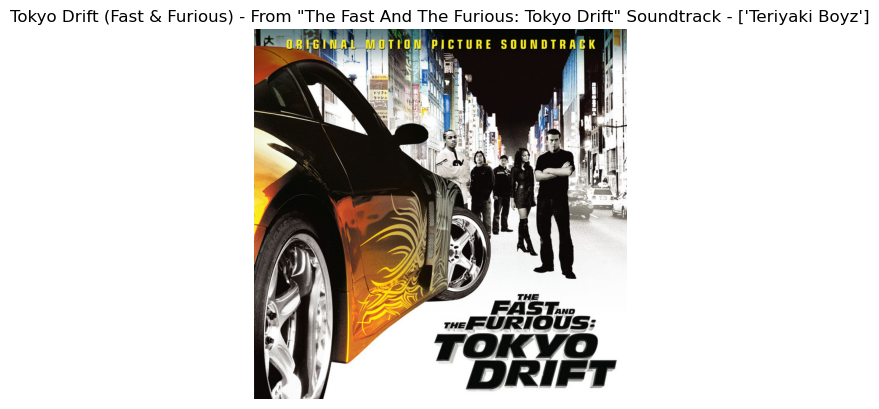

Song URL:  https://open.spotify.com/track/0upFohXrGxIIAjyaJmCkMU


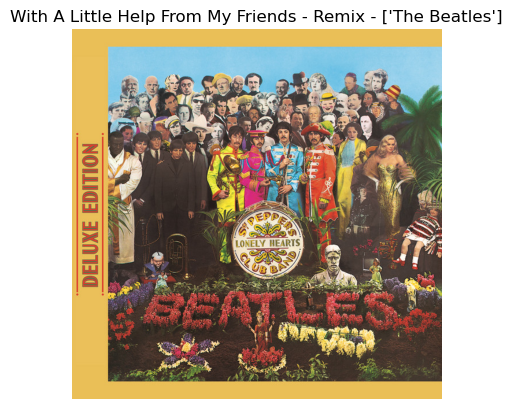

Song URL:  https://open.spotify.com/track/2YsKxAJKUJx93BKxzQ3RTr


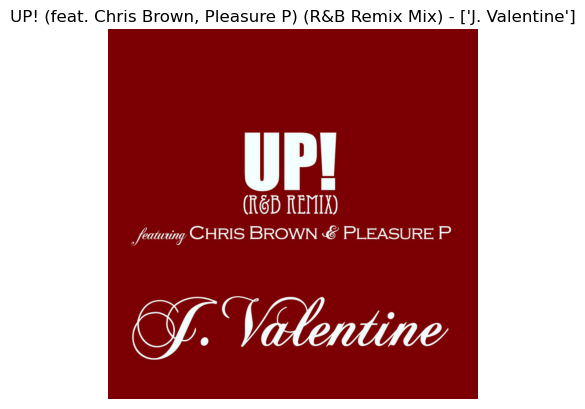

Song URL:  https://open.spotify.com/track/6tZmrNnFao9ofNviYqJwOH


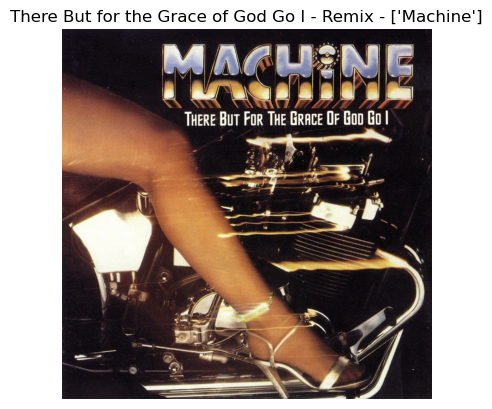

Song URL:  https://open.spotify.com/track/238ktHqrZJtfyoF1xcvfSR


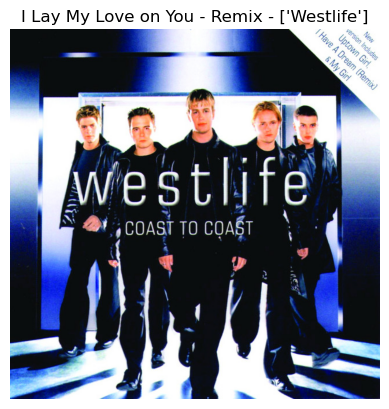

Song URL:  https://open.spotify.com/track/0V82wcNlunw76nvvmPL9tk


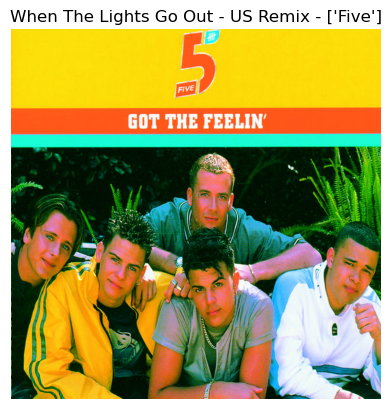

Song URL:  https://open.spotify.com/track/3InhfmTkNJa0ZGZfo7GWzc


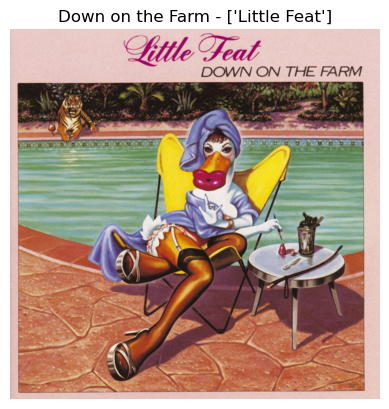

Song URL:  https://open.spotify.com/track/1vF8uo6hiwYmQZptHpiFRk


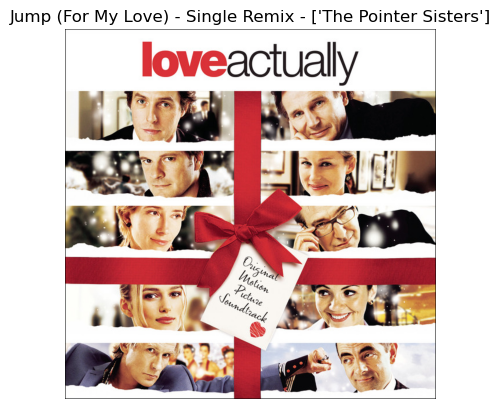

Song URL:  https://open.spotify.com/track/2TIKxe1afsEcYWBvyTgQt3


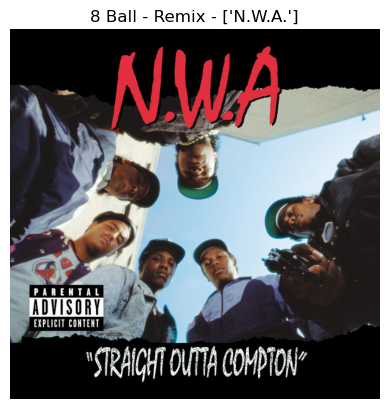

Song URL:  https://open.spotify.com/track/1i0kVfX5LdEdo52St39QM0


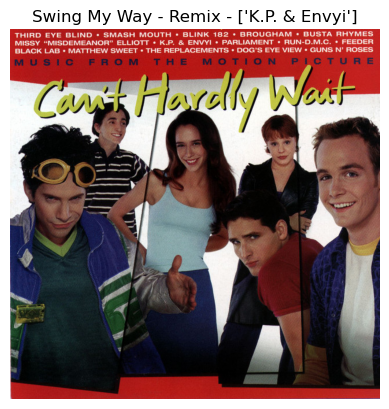

Song URL:  https://open.spotify.com/track/35KcXRWo7BTYdJiyMOy2Zu


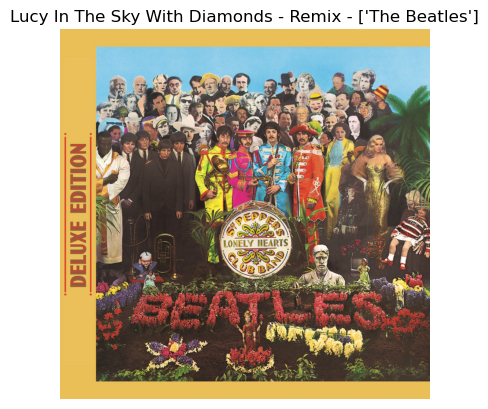

Song URL:  https://open.spotify.com/track/5od7xyJpszivAXNkBc5SL8


In [32]:
from keras.models import load_model
from time import sleep
from tensorflow.keras.utils import img_to_array
from keras.preprocessing import image
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')
classifier =load_model(r'model.h5')

emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)



while True:
    _, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),10)
        roi_gray = gray[y:y+h,x:x+w]
        roi_gray = cv2.resize(roi_gray,(48,48),interpolation=cv2.INTER_AREA)



        if np.sum([roi_gray])!=0:
            roi = roi_gray.astype('float')/255.0
            roi = img_to_array(roi)
            roi = np.expand_dims(roi,axis=0)

            prediction = classifier.predict(roi)[0]
            label=emotion_labels[prediction.argmax()]
            label_position = (x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

finalEmotion=""
print("Prediction array: ",prediction)
maxIndex=0;
max=0;
for i in range(len(prediction)):
    if prediction[i]>max:
        max=prediction[i]
        maxIndex=i

if(maxIndex==0):
    finalEmotion="Angry"
elif(maxIndex==1):
    finalEmotion="Disgust"
elif(maxIndex==2):
    finalEmotion="Fear"
elif(maxIndex==3):
    finalEmotion="Happy"
elif(maxIndex==4):
    finalEmotion="Neutral"
elif(maxIndex==5):
    finalEmotion="Sad"
elif(maxIndex==6):
    finalEmotion="Suprise"
print("Predicted Emotion: ",finalEmotion)
print("Recommended songs are as under: ")
user_id = 'x75tchtjdlipeyza91spkk5i8'
dataset = ChooseDataset(finalEmotion)
user_playlist = get_user_playlist(user_id, playlist_id)
preprocessed_data = preprocess_data(dataset, user_playlist)
recommended_songs = recommend_songs(preprocessed_data, user_playlist)
print(recommended_songs[['name']])
visualize_songs(recommended_songs)